In [1]:
import os
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from tqdm import tqdm

from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [13]:
load_outlier_detector = True

filepath = '/root/.keras/datasets/'  # change to directory where model is downloaded
detector_type = 'outlier'
dataset = 'cifar10'
detector_name = 'OutlierVAE'
filepath = os.path.join(filepath, detector_name)
if load_outlier_detector:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # define model, initialize, train and save outlier detector
    latent_dim = 1024
    
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(4*4*128),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
      ])
    
    # initialize outlier detector
    od = OutlierVAE(threshold=.015,  # threshold for outlier score
                    score_type='mse',  # use MSE of reconstruction error for outlier detection
                    encoder_net=encoder_net,  # can also pass VAE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    latent_dim=latent_dim,
                    samples=2)
    # train
    od.fit(X_train, 
           loss_fn=elbo,
           cov_elbo=dict(sim=.05),
           epochs=50,
           verbose=False)
    
    # save the trained outlier detector
    save_detector(od, filepath)

/usr/local/lib/python3.8/dist-packages/alibi_detect/utils/saving.py:979: UserWarning: Trying to load detector from an older version.This may lead to breaking code or invalid results.
  warnings.warn('Trying to load detector from an older version.'


In [20]:
idx = 8
X = X_train[idx].reshape(1, 32, 32, 3)
X_recon = od.vae(X)
X_lat = od.vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_vae (EncoderVAE)    multiple                  17962688  
                                                                 
 decoder (Decoder)           multiple                  2889027   
                                                                 
Total params: 20,851,715
Trainable params: 20,851,715
Non-trainable params: 0
_________________________________________________________________


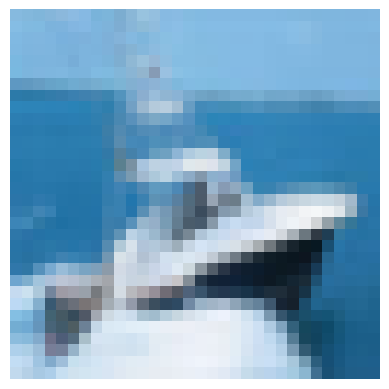

In [7]:
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()

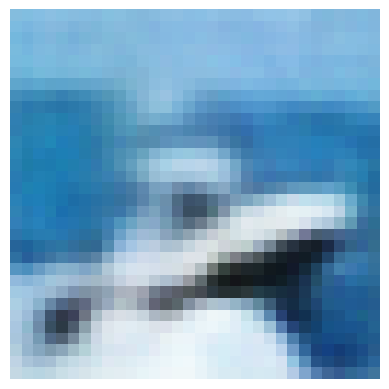

In [8]:
plt.imshow(X_recon.numpy().reshape(32, 32, 3))
plt.axis('off')
plt.show()

In [9]:
X = X_train[:500]
print(X.shape)

(500, 32, 32, 3)


In [10]:
od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
print(list(od_preds['data'].keys()))

['instance_score', 'feature_score', 'is_outlier']


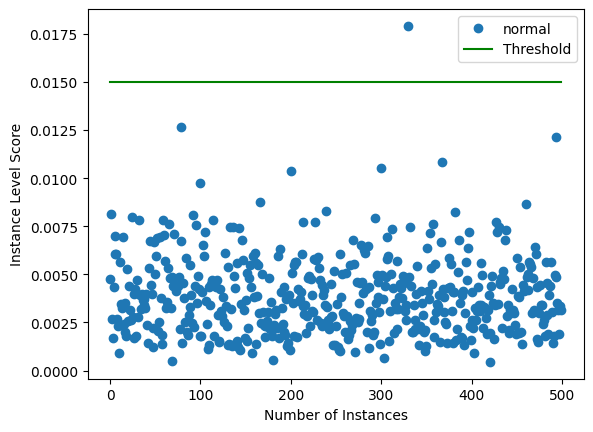

In [11]:

target = np.zeros(X.shape[0],).astype(int)  # all normal CIFAR10 training instances
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

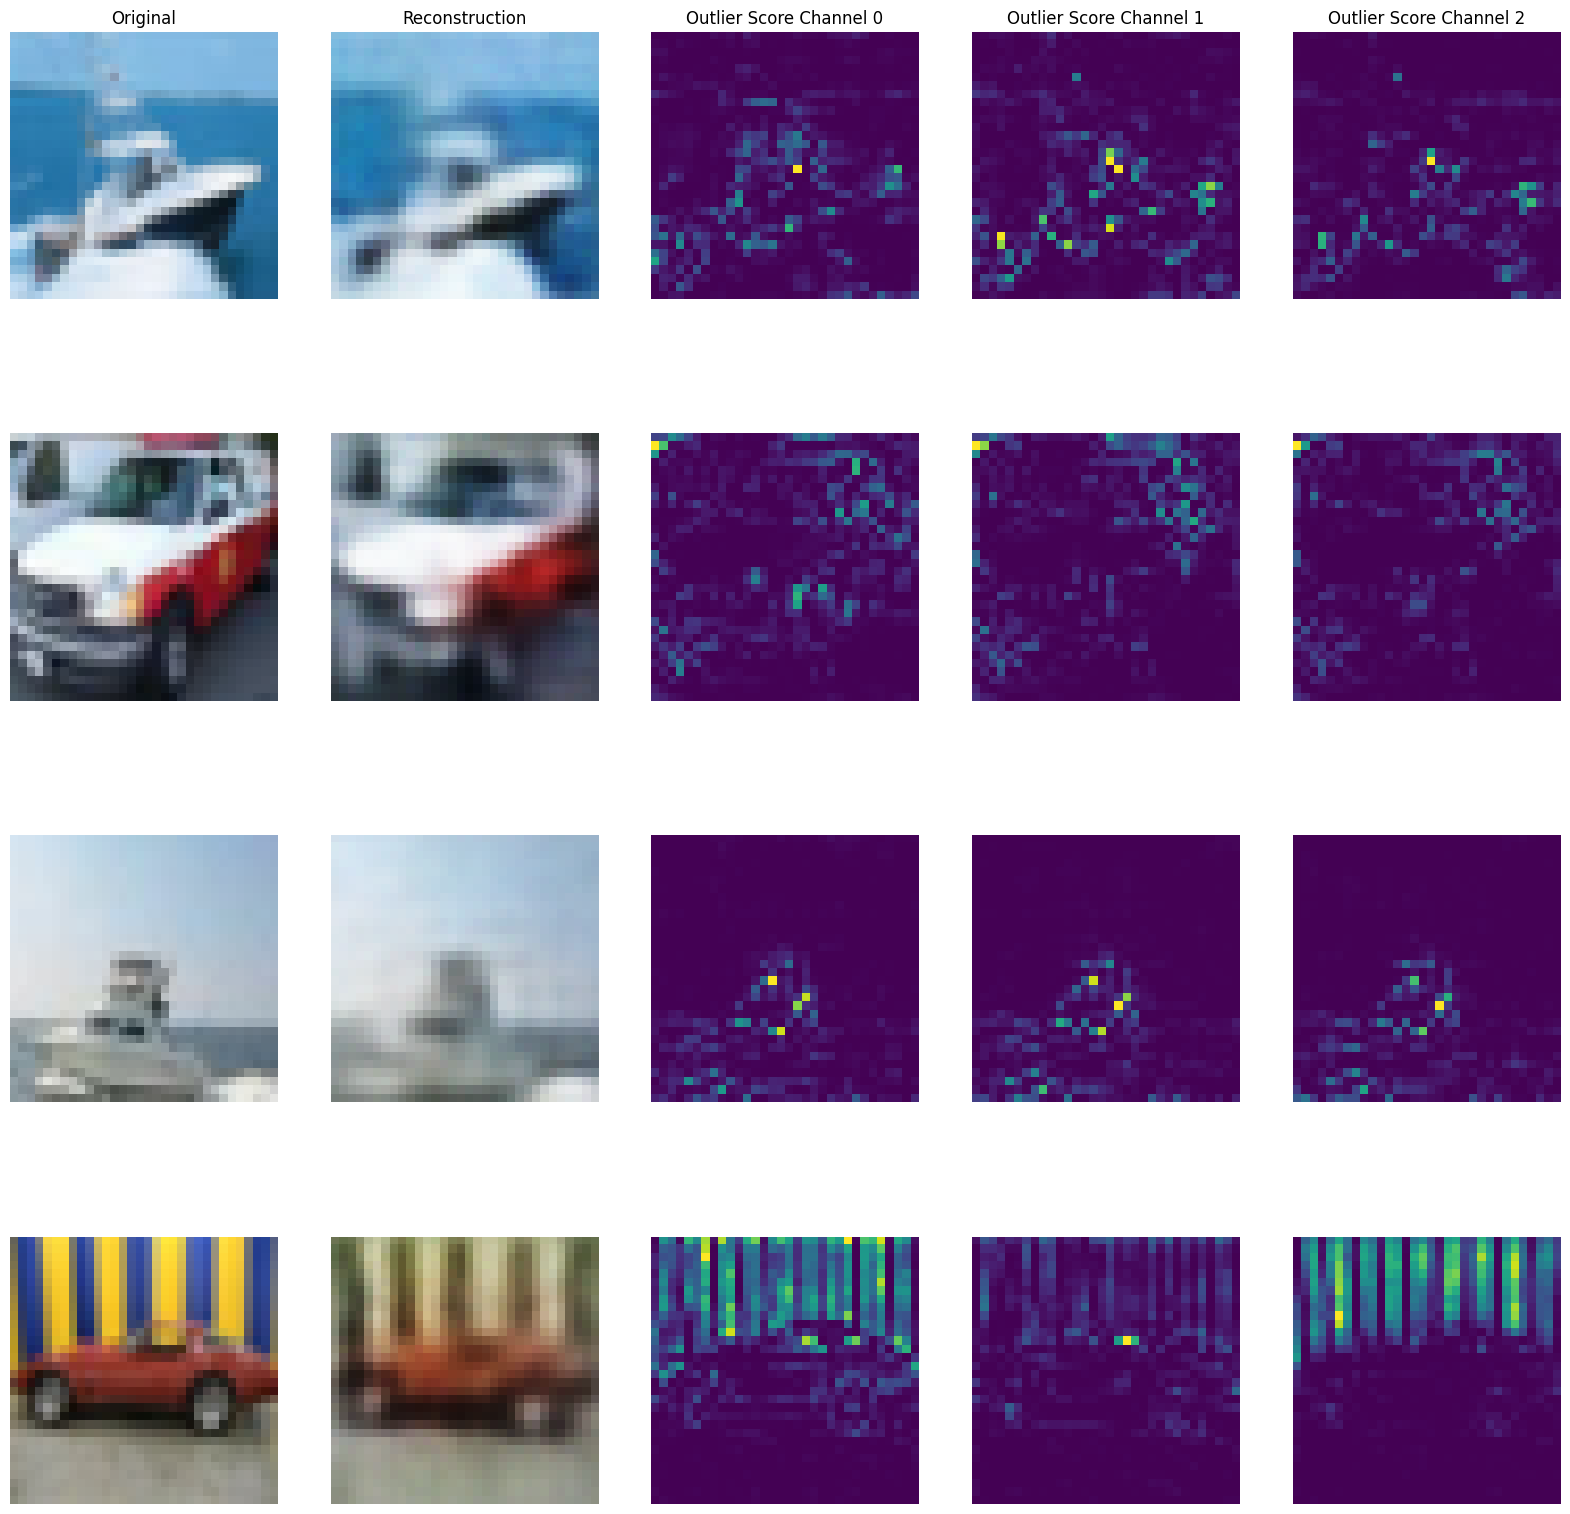

In [12]:
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds, 
                           X, 
                           X_recon=X_recon,
                           instance_ids=[8, 60, 100, 330],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions

In [33]:
od.vae.encoder.encoder_net.summary()
od.vae.decoder.decoder_net.summary()
od.vae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         1049088   
                                                                 
Total params: 1,183,424
Trainable params: 1,183,424
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 reshape (Reshape)      